<a href="https://colab.research.google.com/github/busekabakoglu/FLhierarchicalIDA/blob/main/F_MNIST_IDA_Hiyerar%C5%9Fik_github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install syft
#import syft # send olayini yapacak
import json
import os
import gc
import collections
import numpy as np   # tf icin lazim
import tensorflow as tf 
import copy 
from matplotlib import pyplot as plt
import time
import math
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [ ]:
num_clients = 10
batch_size = 20
learning_rate = 0.01
decay_rate = 0.995
local_epochs = 1
federated_rounds = 300
checkpoint_path = "checkpoint.ckpt"
saving_frequency = 1
is_balanced = True
load_weights = False
current_epoch = {}
if os.path.exists("current_epoch.json"):
  with open('current_epoch.json') as json_file:
    data = json.load(json_file)
    current_epoch = data

In [ ]:
class Utilities:
  @staticmethod
  def add(model1, model2):
    temp = np.multiply(model1, 0)
    for i in range(len(model2)):
        temp[i] = np.add(model1[i], model2[i])
    return temp

  @staticmethod
  def subtract(model1, model2):
    temp = np.multiply(model1, 0)
    for i in range(len(model2)):
        temp[i] = np.subtract(model1[i], model2[i] )
    return temp

  @staticmethod
  def divide(model, number):
    temp = np.multiply(model, 0)
    for i in range(len(model)):
        temp[i] = model[i]/number
    return temp

  @staticmethod
  def flatten_weights(weights):
    flat_ = []
    for layer in weights:
      flat_ = tf.concat([flat_, tf.reshape(layer , [-1, ]) ] , axis=0)
    return flat_

  @staticmethod
  def find_avg_model(client_models, num_clients):
    num_clients = num_clients * 1.0
    total = np.multiply(client_models[0], 0)
    for model in client_models:
      total = Utilities.add(total, model)
    return Utilities.divide(total, num_clients)

  @staticmethod
  def ida_normalization_factor(client_models, avg_model):
    # Z = np.multiply( avg_model , 0 )
    Z = 0.0
    for model in client_models:
      # temp = np.multiply( avg_model , 0 )
      # Going through all layers of the model
      diff = Utilities.subtract(avg_model, model)
      distance = tf.norm(Utilities.flatten_weights(diff), ord=1)
      inv_distance = np.divide(1.0, distance)
      Z = np.add(Z, inv_distance)
      
    return Z
  
  @staticmethod
  def ida_coefficient_of_model(client_model, avg_model, Z ):
    #sub = np.multiply(avg_model, 0.0)
    diff = Utilities.subtract(avg_model, client_model)
    distance = tf.norm(Utilities.flatten_weights(diff) , ord=1)
    inv_distance = np.divide(1.0, distance)
    inv_distance = np.divide(inv_distance, Z)
    return inv_distance

  @staticmethod
  def all_ida_coefficients(client_models, avg_model, Z ):
    coeffs = []
    for model in  client_models:
      coeffs.append( Utilities.ida_coefficient_of_model( model , avg_model , Z ) )
    return coeffs 

In [ ]:
# Buse Version
# train_x = np.load("./mimic_benchmark/X_train.npy")
# train_y = np.load("./mimic_benchmark/y_train.npy")
# test_x = np.load("./mimic_benchmark/X_test.npy")
# test_y = np.load("./mimic_benchmark/y_test.npy")

# Barış Version
# train_x = np.load("./drive/My Drive/X_train.npy")
# train_y = np.load("./drive/My Drive/y_train.npy")
# test_x = np.load("./drive/My Drive/X_test.npy")
# test_y = np.load("./drive/My Drive/y_test.npy")

fmnist_train, fmnist_test = tf.keras.datasets.fashion_mnist.load_data()
train_x, train_y = fmnist_train  # global 
test_x, test_y = fmnist_test     # global  (x, y)
train_x = train_x / 255.0
test_x  = test_x  / 255.0 
train_x = train_x.reshape((train_x.shape[0], 28, 28, 1))
test_x = test_x.reshape((test_x.shape[0], 28, 28, 1))
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(60000, 28, 28, 1)
(60000,)
(10000, 28, 28, 1)
(10000,)


In [ ]:
num_train_data_point = len(train_y) # global
INPUT_SHAPE = train_x.shape[1:]
print(INPUT_SHAPE)

(28, 28, 1)


In [ ]:
# Shuffles 2 arrays side by side
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

# For example we have 10 clients
# We have to distribute the data to these clients


# Balanced Case Using All of the Data (No reuse)
def split_data(distribution_type, num_clients, data_amount = 600):
  if distribution_type == "BALANCED":
    return getBalancedData(num_clients)
  elif distribution_type == "IMBALANCED":
    return get_imbalanced_data(num_clients)
  elif distribution_type == "FIXED_SIZE_BALANCED_DATA":
    return get_fixed_amount_balanced_data(num_clients, data_amount)
  elif distribution_type == "SKEWED":
    return get_skewed_data(num_clients, data_amount)
  elif distribution_type == "IMBALANCED_AND_SKEWED":
    return get_imbalanced_and_skewed_data(num_clients, data_amount)

def getBalancedData( num_clients ):
  x,y = unison_shuffled_copies(train_x, train_y)
  new_x = np.array_split(x, num_clients)
  new_y = np.array_split(y, num_clients)  
  return new_x, new_y

# Imbalanced and Skewed Data
def get_imbalanced_and_skewed_data(num_clients, data_amount = 60000):
  train_index_list = [[], [], [], [], [], [], [], [], [], []]
  new_x = []
  new_y = []
  for i, v in enumerate(train_y):
    train_index_list[v].append(i)

  for i in range(num_clients):
    cur_x, cur_y = make_split_train_data_by_number(i, train_index_list, np.random.randint(1, high=len(train_index_list[i]), dtype=int))
    new_x.append(cur_x)
    new_y.append(cur_y)

  return new_x, new_y

# Skewed Distribution
def get_skewed_data(num_clients, max_size):
  train_index_list = [[], [], [], [], [], [], [], [], [], []]
  new_x = []
  new_y = []
  for i, v in enumerate(train_y):
    train_index_list[v].append(i)
  
  for i in range(len(train_index_list)):
    print(len(train_index_list[i]))

  for i in range(num_clients):
    cur_x = []
    cur_y = []
    for index in train_index_list[i]:
      cur_x.append(train_x[index])
      cur_y.append(train_y[index])
    #cur_x, cur_y = (make_split_train_data_by_number(i, train_index_list, max_size))
    new_x.append(np.array(cur_x))
    new_y.append(np.array(cur_y))

  return new_x, new_y
 
def make_split_train_data_by_number(index_number, train_index_list, size=600):
    if index_number != -1 :
        random_index = np.random.randint(0, high=len(train_index_list[index_number]), size=min(size, len(train_index_list[index_number])))
        s_train_x = []
        s_train_y = []
        for v in random_index:
            s_train_x.append(train_x[train_index_list[index_number][v]])
            s_train_y.append(train_y[train_index_list[index_number][v]])
        return s_train_x, s_train_y
    else:
        return train_x, train_y

# Balanced data 
def get_fixed_amount_balanced_data(num_clients, data_amount):
  x,y = unison_shuffled_copies(train_x, train_y)
  x = x[:num_clients*data_amount]
  y = y[:num_clients*data_amount]
  new_x = np.array_split(x, num_clients)
  new_y = np.array_split(y, num_clients)  
  return new_x, new_y

# Imbalanced Data Distribution
def get_imbalanced_data(num_clients):
  random_data_amounts = np.random.randint(1, high=num_train_data_point//num_clients, size=num_clients, dtype=int)
  print(random_data_amounts)
  x,y = unison_shuffled_copies(train_x, train_y)
  start = 0
  new_x = []
  new_y = []
  for amount in random_data_amounts:
    end = start + amount
    current_x = x[start:end]
    current_y = y[start:end]
    start = end
    new_x.append(current_x)
    new_y.append(current_y)
  return new_x, new_y

# To be used for splitting the data
#fed_x , fed_y = getBalancedData(num_clients)
# fed_x , fed_y = split_data("BALANCED", num_clients)
# fed_x = np.array(fed_x)
# fed_y = np.array(fed_y)
# for y in fed_y:
#   print(len(y))

In [ ]:
def getModel():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Conv2D(
                                  filters= 6,
                                  kernel_size = (5,5),
                                  strides=(1,1),
                                  activation='tanh',
                                  input_shape=INPUT_SHAPE))
  
  model.add(tf.keras.layers.AveragePooling2D(pool_size=(2,2),
                                          strides=(2,2)))
  
  model.add(tf.keras.layers.Conv2D(
                                  filters=16,
                                  kernel_size = (5,5),
                                  strides=(1,1),
                                  activation='tanh'))
  
  model.add(tf.keras.layers.AveragePooling2D(pool_size=(2,2),
                                          strides=(2,2)))
  
  model.add(tf.keras.layers.Flatten())
  
  model.add(tf.keras.layers.Dense(units=120,activation='tanh'))
  
  model.add(tf.keras.layers.Dense(units=84,activation='tanh'))
    
  model.add(tf.keras.layers.Dense(units=10,activation='softmax'))
  return model

def visualize_metrics(metrics, Loss=True):
      # Get training and test loss histories
  count = 0
  acc = metrics["acc"]
  loss = metrics["loss"]
  
  # # Create count of the number of epochs
  epoch_count = range(1, len(acc) + 1)
  # Visualize loss history
  if Loss:
    plt.subplot(2,1,1)
    plt.plot(epoch_count, loss, 'r--')
    plt.legend(['Training Loss'])
    plt.figure(figsize=(10,10))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

  plt.subplot(2,1,2)
  plt.plot(epoch_count, acc, 'b--')
  plt.legend(['Accuracy'])
  plt.xlabel('Epoch')
  plt.ylabel('Acc')
  plt.figure(figsize=(10,10))
  plt.show()

In [ ]:
class Client():
  def __init__(self, id, x, y):
    self.id = id
    self.x = x
    self.y = y
    self.amount_of_data = len(y)
    self.model = getModel()
    self.old_model = []
  def init_session(self, global_model):
    self.model.set_weights( global_model )

  def train_client( self, learning_rate, batch_size, local_epochs, global_model ):
    #old_model = np.array( self.model.get_weights(), dtype=object )
    updated_model = copy.deepcopy(global_model) 
    self.model.set_weights( updated_model )
    optimizer = tf.keras.optimizers.SGD( lr=learning_rate )
    self.model.compile( loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"] )
    self.model.fit( self.x, self.y, epochs=local_epochs, batch_size=batch_size, shuffle=True, verbose=1 )
    new_model = np.array( self.model.get_weights() , dtype=object )
    #gradients = np.subtract( new_model , old_model )
    return new_model

class EdgeServer():
  def __init__( self, client_list, client_indexes, global_model):
    self.client_list = client_list
    self.client_indexes = client_indexes
    self.gradients = np.multiply( np.array(global_model ,dtype=object), 0 )
    self.model_weights = np.array(global_model ,dtype=object)
    self.num_clients = len(client_indexes)
    self.history = {"loss" : [], "acc" :[], "prec" :[] , "recall" : [] }
    self.model = getModel()
    
  
  def train_slaves(self, learning_rate, batch_size, local_epochs, edge_interval, global_interval): # :)
    for round in range(global_interval):
      returned_models_total = np.multiply(self.gradients, 0)
      client_models = []

      for client in self.client_list:
        client_model =  client.train_client(learning_rate, batch_size, edge_interval, self.model_weights)
        returned_models_total = np.add( returned_models_total, client_model ) 
        client_models.append(client_model)

      avg_model = np.divide( returned_models_total , self.num_clients )
      Z = Utilities.ida_normalization_factor(client_models, avg_model)
      ida_factors = Utilities.all_ida_coefficients(client_models, avg_model, Z)
      weighted_total_client_models = np.multiply(self.gradients, 0)

      for i in range(len(client_models)):
        weighted_total_client_models = np.add(weighted_total_client_models, np.multiply( client_models[i] , ida_factors[i] ) )

      self.model_weights = weighted_total_client_models

      self.model.set_weights(self.model_weights)

      optimizer = tf.keras.optimizers.SGD(lr=learning_rate)
      self.model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,metrics=["accuracy", 
               tf.keras.metrics.AUC(curve='PR', multi_label=True),
               tf.keras.metrics.AUC(curve="ROC"),
               tf.keras.metrics.Precision(top_k=1),
               tf.keras.metrics.Recall(top_k=1),
               tf.keras.metrics.FalseNegatives(),
               tf.keras.metrics.FalsePositives(),
               ])
      
      self.model.evaluate( test_x , test_y )
      self.history['loss'].append(current_state[0])
      self.history['acc'].append(current_state[1])
      self.history["prec"].append(current_state[2])
      self.history["recall"].append(current_state[3])

      return self.model_weights
    
class Server():
  def __init__(self, num_clients, num_edge_servers, distribution, edge_interval, global_interval, load_weights=False, visualization_freq=30 ):
    self.history = {"loss" : [], "acc" :[] }
    self.model = getModel()
    self.num_clients = num_clients
    self.num_edge_servers = num_edge_servers
    self.gradients = np.multiply( np.array(self.model.get_weights() ,dtype=object), 0 )
    self.clients = []
    self.edge_servers = []
    self.visualization_freq = visualization_freq
    self.curr_epoch = 0
    self.distribution = distribution
    self.edge_interval = edge_interval
    self.global_interval = global_interval
    self.init_clients()
    self.init_edge_servers()

  def train_slave_masters(self, learning_rate, batch_size, local_epochs, edge_interval, global_interval, federated_rounds, decay_rate):
    # self.init_clients()
    # self.init_edge_servers()

    for round in range(federated_rounds):
      returned_models = np.multiply(self.gradients, 0)
      edge_models = [] 
      if round % 4 == 0 :
        self.clear_backend()
      
      for edge_server in self.edge_servers: 
        edge_model = edge_server.train_slaves(learning_rate, batch_size, local_epochs, edge_interval, global_interval) 
        returned_models = np.add(returned_models, edge_model)
        edge_models.append(edge_model)
      
      avg_model = np.divide( returned_models, len(self.edge_servers) )
      Z = Utilities.ida_normalization_factor(edge_models, avg_model)
      ida_factors = Utilities.all_ida_coefficients(edge_models, avg_model, Z)
      updated_model = np.multiply(self.gradients, 0)
      for i in range(len(edge_models)):
        updated_model = np.add(updated_model, np.multiply( edge_models[i] , ida_factors[i] ) )
      self.model.set_weights(updated_model)
      optimizer = tf.keras.optimizers.SGD(lr=learning_rate)
      self.model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
      print(""".... EPOCH {} DONE ....""".format(round))
      current_state = self.model.evaluate( train_x, train_y )
      self.model.evaluate( test_x , test_y )
      self.history['loss'].append(current_state[0])
      self.history['acc'].append(current_state[1])
      if round != 0 and round % self.visualization_freq == 0 : 
        visualize_metrics(self.history)
      learning_rate = learning_rate  * decay_rate
      
  def init_clients(self):
    weight_factors = []
    total_data = 0
    for i in range(self.num_clients):
      self.clients.append( Client( i, fed_x[ i ], fed_y[ i ] ) )
    
    initial_model = np.array( self.model.get_weights(), dtype=object )
    for client in self.clients:
      client.init_session(initial_model)
      #burda niye amount of data eklemişiz :
      # FedAvg'dan kalma,  Gerek yok aslinda ama zararı da yok bundan sonraki 2 satırın
      weight_factors.append(client.amount_of_data)
      total_data += client.amount_of_data
    self.weight_factors = np.array(weight_factors) / float(total_data)

  def init_edge_servers(self):
    edge = self.num_edge_servers
    client_number = self.num_clients//self.num_edge_servers
    for i in range(self.num_edge_servers):
      self.edge_servers.append( EdgeServer( [], [], self.model.get_weights() ) )
    for i in range(self.num_clients):
      edge_index = i//client_number
      self.edge_servers[edge_index].client_list.append(self.clients[i])
      self.edge_servers[edge_index].client_indexes.append(i)
      self.edge_servers[edge_index].num_clients += 1
    print( "... EDGE SERVERS INITIALIZED ..." )
      
  

  def clear_backend(self):
    print("CLEARING BACKEND....")
    saved_weights = self.model.get_weights() 
    tf.keras.backend.clear_session()
    gc.collect()
    self.model.set_weights(saved_weights)
    del self.clients
    self.clients = []
    del self.edge_servers
    self.edge_servers = []
    self.init_clients()
    self.init_edge_servers() 
    # for client in self.clients:
      # client.model.set_weights(saved_weights)
    print("BACKEND CLEARED!")

  

... EDGE SERVERS INITIALIZED ...
CLEARING BACKEND....
... EDGE SERVERS INITIALIZED ...
BACKEND CLEARED!
Epoch 1/2
300/300 [==============================] - 1s 3ms/step - loss: 1.9582 - accuracy: 0.3442
Epoch 2/2
300/300 [==============================] - 1s 3ms/step - loss: 1.0148 - accuracy: 0.6711
Epoch 1/2
300/300 [==============================] - 1s 3ms/step - loss: 1.9652 - accuracy: 0.3276
Epoch 2/2
300/300 [==============================] - 1s 3ms/step - loss: 1.0128 - accuracy: 0.6691
Epoch 1/2
300/300 [==============================] - 1s 3ms/step - loss: 1.9583 - accuracy: 0.3164
Epoch 2/2
300/300 [==============================] - 1s 3ms/step - loss: 1.0134 - accuracy: 0.6683
Epoch 1/2
300/300 [==============================] - 1s 3ms/step - loss: 1.9524 - accuracy: 0.3462
Epoch 2/2
300/300 [==============================] - 1s 3ms/step - loss: 1.0111 - accuracy: 0.6623
Epoch 1/2
300/300 [==============================] - 1s 3ms/step - loss: 1.9694 - accuracy: 0.3175
Epoch

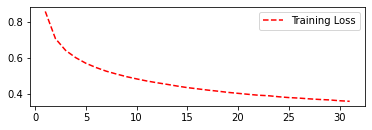

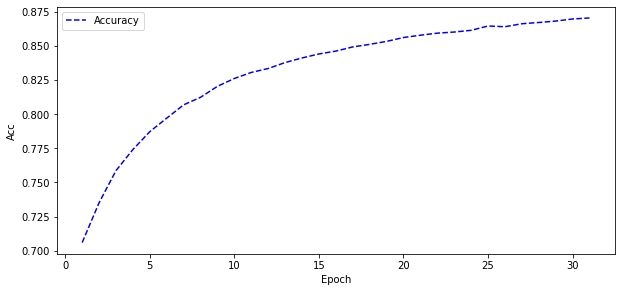

<Figure size 720x720 with 0 Axes>

Epoch 1/2
300/300 [==============================] - 1s 3ms/step - loss: 0.3692 - accuracy: 0.8733
Epoch 2/2
300/300 [==============================] - 1s 3ms/step - loss: 0.3575 - accuracy: 0.8770
Epoch 1/2
300/300 [==============================] - 1s 3ms/step - loss: 0.3755 - accuracy: 0.8683
Epoch 2/2
300/300 [==============================] - 1s 4ms/step - loss: 0.3460 - accuracy: 0.8687
Epoch 1/2
300/300 [==============================] - 1s 3ms/step - loss: 0.3709 - accuracy: 0.8645
Epoch 2/2
300/300 [==============================] - 1s 3ms/step - loss: 0.3565 - accuracy: 0.8704
Epoch 1/2
300/300 [==============================] - 1s 3ms/step - loss: 0.3698 - accuracy: 0.8663
Epoch 2/2
300/300 [==============================] - 1s 3ms/step - loss: 0.3381 - accuracy: 0.8760
Epoch 1/2
300/300 [==============================] - 1s 3ms/step - loss: 0.3766 - accuracy: 0.8603
Epoch 2/2
300/300 [==============================] - 1s 3ms/step - loss: 0.3909 - accuracy: 0.8537
Epoch 1/2


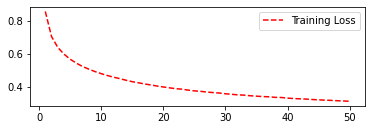

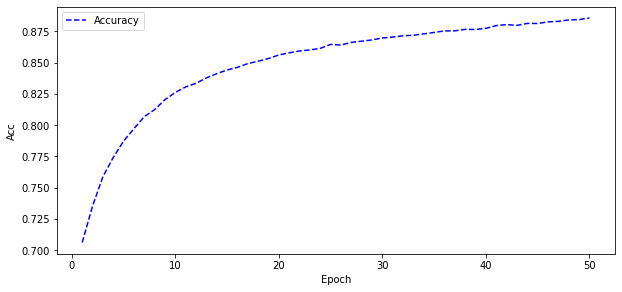

<Figure size 720x720 with 0 Axes>

HISTORY : 


In [ ]:
# BALANCED CASE
distribution = "BALANCED"
fed_x , fed_y = split_data(distribution, num_clients)
fed_x = np.array(fed_x)
fed_y = np.array(fed_y)

server1 = Server( num_clients, 2, distribution, edge_interval=1, global_interval=3, load_weights=False, visualization_freq=30)
# server1.model.summary()
server1.train_slave_masters(learning_rate, batch_size, local_epochs, 2, 3, 50, decay_rate)

optimizer = tf.keras.optimizers.SGD(lr=learning_rate)
server1.model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

print("TEST SET EVALUATION")
print(server1.model.evaluate(test_x , test_y))
visualize_metrics(server1.history)

print("HISTORY : ")
print(server1.model.history)

In [ ]:
# SKEWED CASE
distribution = "SKEWED"
fed_x , fed_y = split_data(distribution, num_clients)
fed_x = np.array(fed_x)
fed_y = np.array(fed_y)

server1 = Server(num_clients, distribution, load_weights=False)
server1.init_clients()
server1.model.summary()
server1.train_slaves(learning_rate, batch_size, local_epochs, federated_rounds)

optimizer = tf.keras.optimizers.SGD(lr=learning_rate)
server1.model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

print("TEST SET EVALUATION")
print(server1.model.evaluate(test_x , test_y))
visualize_metrics(server1.history)

print("HISTORY : ")
print(server1.model.history)

6000
6000
6000
6000
6000
6000
6000
6000
6000
6000


TypeError: ignored

In [ ]:
optimizer = tf.keras.optimizers.SGD(lr=learning_rate)
server.model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
a = server.model.evaluate(test_x , test_y)
history = server.model.history
print(a)
print(history.history)

In [ ]:
# server.train_slaves(0.001, batch_size, local_epochs, 20)

In [ ]:
# IMBALANCED CASE
distribution = "FIXED_SIZE_BALANCED_DATA"
fed_x , fed_y = split_data(distribution, num_clients)
fed_x = np.array(fed_x)
fed_y = np.array(fed_y)

server2 = Server(num_clients, distribution, load_weights=load_weights)
server2.init_clients()
server2.model.summary()
server2.train_slaves(learning_rate, batch_size, local_epochs, federated_rounds)

optimizer = tf.keras.optimizers.SGD(lr=learning_rate)
server2.model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

print("TEST SET EVALUATION")
print(server2.model.evaluate(test_x , test_y))
visualize_metrics(server2.history)

print("HISTORY : ")
print(server2.model.history)

In [ ]:
# a = getModel()
# a.compile(optimizer=tf.optimizers.SGD(), loss="sparse_categorical_crossentropy")
# a.fit(train_x, train_y, epochs=1, shuffle=True, verbose=1)

In [ ]:
shapes = [
          [784, 10],
          [10]
]
aa = np.array(server.model.get_weights(), dtype=object)

def flatten_weights(weights, shape=shapes):
  flat_ = []
  for layer in weights:
    flat_ = tf.concat([flat_, tf.reshape(layer , [-1, ]) ] , axis=0)
  return flat_
l = flatten_weights(aa)

b = tf.Variable(l, trainable=True, dtype=tf.float32)

tf.norm(b)